## 1. 化學資訊學概論 (Introduction)

化學資訊學 (Cheminformatics) 是化學、電腦科學與資訊科學的交叉學科。其核心挑戰在於：**如何讓電腦「理解」化學分子？**

電腦無法直接處理燒杯中的化學物質，也無法直接「看」結構式圖片。我們必須將分子轉化為電腦可運算的資料結構（如字串、圖形或向量）。這也是 **QSAR (Quantitative Structure-Activity Relationship)** 的基礎假設：**相似的化學結構通常具有相似的生物活性或物理化學性質**。

## 2. 環境設定與套件安裝

In [1]:
# 安裝 RDKit（如果尚未安裝）
# 在 Colab 環境中執行
try:
    import rdkit
    print(f"RDKit 版本: {rdkit.__version__}")
except ImportError:
    print("正在安裝 RDKit...")
    !pip install rdkit -q
    import rdkit
    print(f"RDKit 已安裝，版本: {rdkit.__version__}")

RDKit 版本: 2025.09.2


In [2]:
# 匯入必要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, AllChem
from rdkit.Chem import DataStructs

# 設定專案根目錄與輸出目錄
REPO_ROOT = Path.cwd().parent if Path.cwd().name == 'Part_2' else Path.cwd()
OUTPUT_DIR = REPO_ROOT / 'Part_2' / 'P2_Unit08_Cheminfo_Results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 設定中文字型（用於圖表顯示）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("套件載入完成！")
print(f"輸出目錄: {OUTPUT_DIR}")

套件載入完成！
輸出目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2\P2_Unit08_Cheminfo_Results


## 3. 分子表示法 (Molecular Representation)

### 3.1 SMILES (Simplified Molecular Input Line Entry System)

SMILES 是一種基於 ASCII 字串的線性表示法，利用簡單的語法規則來描述 2D 化學結構。

**語法規則詳解**：
1.  **原子**：使用元素符號（如 `C`, `N`, `O`, `S`, `P`）。有機子集外的元素需加括號（如 `[Au]`）。
2.  **鍵結**：單鍵通常省略，雙鍵用 `=`，三鍵用 `#`，芳香鍵用 `:`。
3.  **分支**：使用圓括號 `()` 表示側鏈。例如 `CC(O)C` 代表異丙醇。
4.  **環**：使用數字標記斷開的鍵（如 `C1...C1`）。環己烷為 `C1CCCCC1`。
5.  **芳香性**：使用小寫字母（如 `c`, `n`）表示芳香環中的原子。苯為 `c1ccccc1`。

In [3]:
# 定義範例分子的 SMILES
molecules = {
    "Benzene": "c1ccccc1",
    "Ethanol": "CCO",
    "Aspirin": "CC(=O)Oc1ccccc1C(=O)O",
    "Caffeine": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "Ibuprofen": "CC(C)Cc1ccc(cc1)C(C)C(=O)O"
}

# 將 SMILES 轉換為 RDKit 分子物件
mol_objects = {}
for name, smiles in molecules.items():
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol_objects[name] = mol
        print(f"{name}: {smiles} ✓")
    else:
        print(f"{name}: SMILES 解析失敗！")

print(f"\n成功解析 {len(mol_objects)} 個分子")

Benzene: c1ccccc1 ✓
Ethanol: CCO ✓
Aspirin: CC(=O)Oc1ccccc1C(=O)O ✓
Caffeine: CN1C=NC2=C1C(=O)N(C(=O)N2C)C ✓
Ibuprofen: CC(C)Cc1ccc(cc1)C(C)C(=O)O ✓

成功解析 5 個分子


### 3.2 分子結構視覺化

分子結構圖已儲存至 g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2\P2_Unit08_Cheminfo_Results\molecules_grid.png


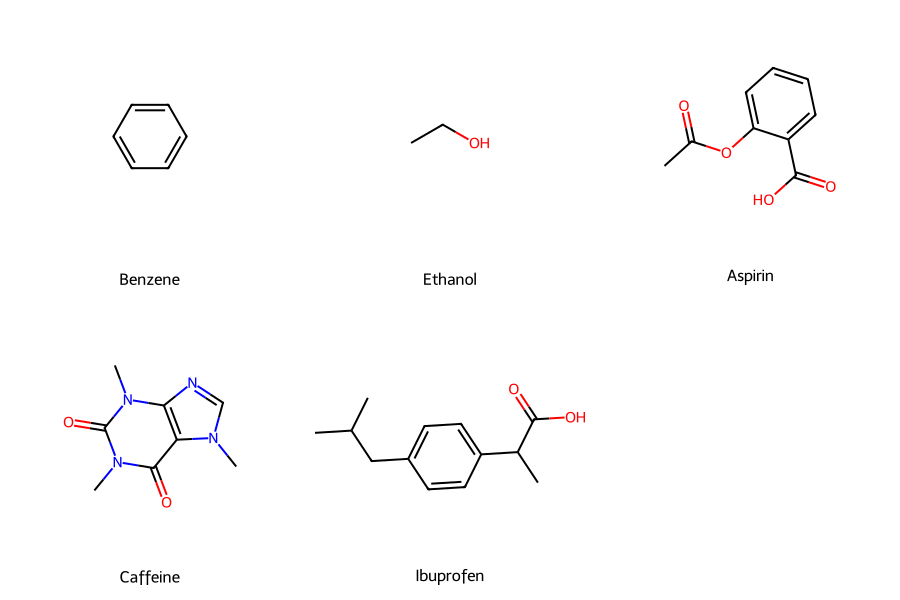

In [4]:
# 繪製分子結構網格圖
mol_list = list(mol_objects.values())
legends = list(mol_objects.keys())

# 使用 RDKit 的繪圖功能並保存
img_path = OUTPUT_DIR / "molecules_grid.png"
img = Draw.MolsToGridImage(
    mol_list,
    legends=legends,
    molsPerRow=3,
    subImgSize=(300, 300),
    returnPNG=False  # 返回 PIL Image
)

# 將 PIL Image 保存
from PIL import Image as PILImage
if isinstance(img, PILImage.Image):
    img.save(str(img_path))
else:
    # 使用 matplotlib 替代方案
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for idx, (mol, legend) in enumerate(zip(mol_list, legends)):
        row, col = idx // 3, idx % 3
        axes[row, col].imshow(Draw.MolToImage(mol, size=(300, 300)))
        axes[row, col].set_title(legend)
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.savefig(str(img_path), dpi=150, bbox_inches='tight')
    plt.close()

print(f"分子結構圖已儲存至 {img_path}")

# 顯示圖片
img

## 4. 分子描述子 (Molecular Descriptors)

為了建立機器學習模型（如 QSAR），我們需要將非結構化的分子圖轉化為固定長度的數值向量 $\mathbf{x} \in \mathbb{R}^d$。這些數值特徵稱為描述子。

### 4.1 常用描述子計算

In [5]:
# 計算分子描述子
descriptor_data = []

for name, mol in mol_objects.items():
    descriptor_data.append({
        "Name": name,
        "MW": round(Descriptors.MolWt(mol), 2),  # 分子量
        "LogP": round(Descriptors.MolLogP(mol), 2),  # 辛醇-水分配係數
        "HBD": Descriptors.NumHDonors(mol),  # 氫鍵給體數
        "HBA": Descriptors.NumHAcceptors(mol),  # 氫鍵受體數
        "TPSA": round(Descriptors.TPSA(mol), 2)  # 拓撲極性表面積
    })

df_descriptors = pd.DataFrame(descriptor_data)
print("分子描述子計算結果：")
print(df_descriptors.to_string(index=False))

# 儲存為 CSV
csv_path = OUTPUT_DIR / "molecular_descriptors.csv"
df_descriptors.to_csv(csv_path, index=False)
print(f"\n描述子已儲存至 {csv_path}")

分子描述子計算結果：
     Name     MW  LogP  HBD  HBA  TPSA
  Benzene  78.11  1.69    0    0  0.00
  Ethanol  46.07 -0.00    1    1 20.23
  Aspirin 180.16  1.31    1    3 63.60
 Caffeine 194.19 -1.03    0    6 61.82
Ibuprofen 206.28  3.07    1    1 37.30

描述子已儲存至 g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2\P2_Unit08_Cheminfo_Results\molecular_descriptors.csv


### 4.2 Lipinski's Rule of 5 檢查

這是評估化合物是否具備「類藥性 (Drug-likeness)」的經典經驗法則。口服藥物通常符合：
1.  氫鍵給體 (HBD) $\le 5$
2.  氫鍵受體 (HBA) $\le 10$
3.  分子量 (MW) $\le 500$
4.  LogP $\le 5$

In [6]:
# 檢查 Lipinski's Rule of 5
def check_lipinski(row):
    violations = 0
    if row['HBD'] > 5:
        violations += 1
    if row['HBA'] > 10:
        violations += 1
    if row['MW'] > 500:
        violations += 1
    if row['LogP'] > 5:
        violations += 1
    return violations

df_descriptors['Lipinski_Violations'] = df_descriptors.apply(check_lipinski, axis=1)

print("Lipinski's Rule of 5 檢查結果：")
print(df_descriptors[['Name', 'MW', 'LogP', 'HBD', 'HBA', 'Lipinski_Violations']].to_string(index=False))

print("\n✓ 違反規則數為 0 表示符合類藥性標準")

Lipinski's Rule of 5 檢查結果：
     Name     MW  LogP  HBD  HBA  Lipinski_Violations
  Benzene  78.11  1.69    0    0                    0
  Ethanol  46.07 -0.00    1    1                    0
  Aspirin 180.16  1.31    1    3                    0
 Caffeine 194.19 -1.03    0    6                    0
Ibuprofen 206.28  3.07    1    1                    0

✓ 違反規則數為 0 表示符合類藥性標準


## 5. 分子指紋 (Molecular Fingerprints)

### 5.1 Morgan Fingerprints (ECFP)

Morgan Fingerprints 是目前藥物發現中最常用的指紋，類似於圖卷積 (Graph Convolution) 的概念。

In [7]:
# 計算 Morgan Fingerprints (radius=2, 相當於 ECFP4)
fingerprints = {}

for name, mol in mol_objects.items():
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fingerprints[name] = fp
    # 計算有多少位元被設為 1
    on_bits = fp.GetNumOnBits()
    print(f"{name}: {on_bits}/2048 bits ON")

print("\nMorgan Fingerprints 計算完成！")

Benzene: 3/2048 bits ON
Ethanol: 6/2048 bits ON
Aspirin: 24/2048 bits ON
Caffeine: 25/2048 bits ON
Ibuprofen: 25/2048 bits ON

Morgan Fingerprints 計算完成！


[13:01:33] DEPRECATION WARNING: please use MorganGenerator
[13:01:33] DEPRECATION WARNING: please use MorganGenerator
[13:01:33] DEPRECATION WARNING: please use MorganGenerator
[13:01:33] DEPRECATION WARNING: please use MorganGenerator
[13:01:33] DEPRECATION WARNING: please use MorganGenerator


### 5.2 分子相似度計算 (Tanimoto Coefficient)

根據 **相似性原理 (Similarity Principle)**：結構相似的分子通常具有相似的性質。

我們常用 **Tanimoto Coefficient (Jaccard Index)** 來量化兩個二元指紋向量的相似度：

$$ T(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{c}{a + b - c} $$

In [8]:
# 計算所有分子與 Aspirin 的相似度
reference_mol = "Aspirin"
reference_fp = fingerprints[reference_mol]

similarity_results = []

for name, fp in fingerprints.items():
    similarity = DataStructs.TanimotoSimilarity(reference_fp, fp)
    similarity_results.append({
        "Molecule": name,
        f"Similarity_to_{reference_mol}": round(similarity, 4)
    })

df_similarity = pd.DataFrame(similarity_results).sort_values(
    by=f"Similarity_to_{reference_mol}",
    ascending=False
)

print(f"各分子與 {reference_mol} 的 Tanimoto 相似度：")
print(df_similarity.to_string(index=False))

# 儲存結果
df_similarity.to_csv(OUTPUT_DIR / "similarity_to_aspirin.csv", index=False)
print(f"\n相似度結果已儲存至 {OUTPUT_DIR / 'similarity_to_aspirin.csv'}")

各分子與 Aspirin 的 Tanimoto 相似度：
 Molecule  Similarity_to_Aspirin
  Aspirin                 1.0000
Ibuprofen                 0.1951
  Benzene                 0.1250
  Ethanol                 0.1111
 Caffeine                 0.0889

相似度結果已儲存至 g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2\P2_Unit08_Cheminfo_Results\similarity_to_aspirin.csv


## 6. 子結構搜尋 (Substructure Search)

在藥物篩選中，我們常需篩選含有特定 **藥效團 (Pharmacophore)** 或 **毒性警示結構 (Toxicophore)** 的分子。

### 6.1 搜尋含有羧酸 (Carboxylic Acid) 的分子

In [9]:
# 定義 SMARTS 模式：羧酸 (Carboxylic Acid)
# SMARTS Pattern: C(=O)[OH]
pattern = Chem.MolFromSmarts("C(=O)[OH]")

# 搜尋含有此子結構的分子
matches = {}

for name, mol in mol_objects.items():
    if mol.HasSubstructMatch(pattern):
        matches[name] = mol
        print(f"✓ {name} 含有羧酸結構")
    else:
        print(f"✗ {name} 不含羧酸結構")

print(f"\n共找到 {len(matches)} 個含有羧酸的分子")

✗ Benzene 不含羧酸結構
✗ Ethanol 不含羧酸結構
✓ Aspirin 含有羧酸結構
✗ Caffeine 不含羧酸結構
✓ Ibuprofen 含有羧酸結構

共找到 2 個含有羧酸的分子


### 6.2 視覺化子結構匹配

In [10]:
# 繪製匹配結果（高亮顯示子結構）
if len(matches) > 0:
    match_mols = []
    match_legends = []
    
    for name, mol in matches.items():
        match_mols.append(mol)
        match_legends.append(f"{name} (含羧酸)")
    
    # 使用 RDKit 繪圖並保存
    img_path = OUTPUT_DIR / "substructure_match.png"
    img = Draw.MolsToGridImage(
        match_mols,
        legends=match_legends,
        molsPerRow=2,
        subImgSize=(400, 400),
        highlightAtomLists=[mol.GetSubstructMatch(pattern) for mol in match_mols],
        returnPNG=False  # 返回 PIL Image
    )
    
    # 儲存圖片
    from PIL import Image as PILImage
    if isinstance(img, PILImage.Image):
        img.save(str(img_path))
    else:
        # 使用 matplotlib 替代方案
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, len(match_mols), figsize=(8 * len(match_mols), 8))
        if len(match_mols) == 1:
            axes = [axes]
        for idx, (mol, legend) in enumerate(zip(match_mols, match_legends)):
            axes[idx].imshow(Draw.MolToImage(mol, size=(400, 400), 
                                            highlightAtoms=mol.GetSubstructMatch(pattern)))
            axes[idx].set_title(legend)
            axes[idx].axis('off')
        plt.tight_layout()
        plt.savefig(str(img_path), dpi=150, bbox_inches='tight')
        plt.close()
    
    print(f"子結構匹配結果已儲存至 {img_path}")
    
    # 顯示圖片
    img
else:
    print("沒有找到符合的分子")

子結構匹配結果已儲存至 g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2\P2_Unit08_Cheminfo_Results\substructure_match.png


## 7. 總結與展望

本附錄展示了從 **SMILES** $\to$ **RDKit Mol** $\to$ **Descriptors** 的完整流程。
這就是 **QSAR (Quantitative Structure-Activity Relationship)** 的基礎：
$$ \text{Activity} = f(\text{Descriptors}) $$

在實際應用中，我們會計算數百個描述子（X），搭配實驗測得的生物活性（y），沿用你在 Unit05–Unit08 建立的 scikit-learn 建模流程（切分/交叉驗證/選模），搭配如 Random Forest、Gradient Boosting 等模型來預測新分子的藥效，從而加速新藥開發流程。

### 延伸學習資源
- **RDKit 官方文件**: https://www.rdkit.org/docs/
- **QSAR Modeling**: 可結合 Unit05-06 的監督式學習方法
- **圖神經網路 (GNN)**: 處理分子的深度學習方法（進階主題）

---

**恭喜完成 Unit08 附錄學習！** 🎉